Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.8 MB/s 
     |████████████████████████████████| 120 kB 86.0 MB/s 
     |████████████████████████████████| 6.6 MB 72.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c71468628079e163b73c09772337db080c3f0299f4ad0a7c55b40db42da7f4ee
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

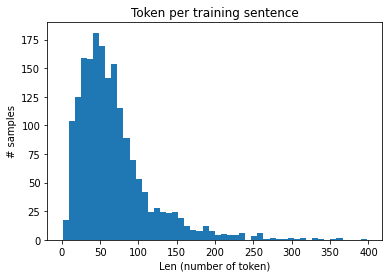

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

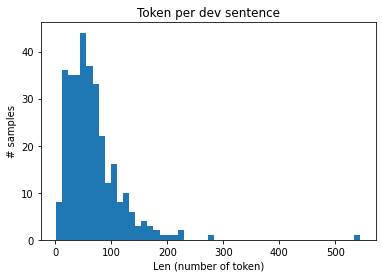

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

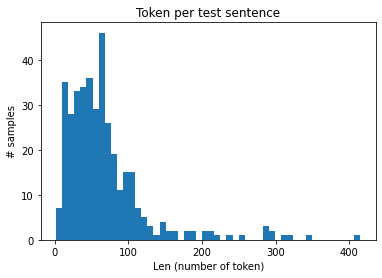

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

8577
663.133,14
0
B-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 908
Points in y_train before removal: 908


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[2201, 10868, 9306, 7508, 5505, 6989, 12838, 10215, 6989, 842, 8858, 8118, 7826, 7798, 7428, 9916, 12742, 4010, 2260, 11609, 6989, 8118, 13420, 8208, 4010, 11263, 2964, 6992, 587, 12395, 1605, 12780, 6989, 6787, 6123, 2912, 11102, 4010, 4730, 9250, 6198, 8685, 11703, 1338, 12391, 5408, 13226, 2067, 2964, 8572, 10703, 6989, 6901, 4010, 4437, 9035, 10372, 12063, 8118, 7212, 4010, 1565, 3668, 9250, 12622, 5408, 12731, 10868]
[1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[978, 8357, 6989, 4354, 2912, 8727, 8706, 2964, 3652, 9916, 559, 4718, 5053, 13372, 6658, 9916, 10019, 9916, 6971, 3092, 6989, 5415, 487, 1395, 3764, 5230, 8318, 6141, 12701, 9916, 10813, 339, 13388, 13302, 6901, 13420, 5014, 2275, 9916, 10445, 5138, 8318, 3246, 6989, 8318, 10815, 6989, 13232, 8348, 8318, 3935, 10142, 10427, 364, 9250, 2214, 2709, 12391, 7508, 6881, 

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 28.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 27.7 MB/s 
     |████████████████████████████████| 163 kB 76.7 MB/s 
     |████████████████████████████████| 7.6 MB 88.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=423e69a6bb5f81829a723c82324c635a8a7b097acd9c2ba7df8744389b862a50
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[2201, 10868, 9306, 7508, 5505, 6989, 12838, 10215, 6989, 

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.34244704246521
Training loss epoch: 0.1116178243775183
Training accuracy epoch: 0.960518231764792
Validating model...
Validation Loss: 0.02015925766456695
Validation Accuracy: 0.9941048137531434
Training epoch: 2
Training loss per 100 training steps: 0.013848504051566124
Training loss epoch: 0.018819440695667038
Training accuracy epoch: 0.9946415824217392
Validating model...
Validation Loss: 0.014287694135592097
Validation Accuracy: 0.9959591638197377
Training epoch: 3
Training loss per 100 training steps: 0.012212748639285564
Training loss epoch: 0.010160744661616134
Training accuracy epoch: 0.9968701074785477
Validating model...
Validation Loss: 0.016498777688303518
Validation Accuracy: 0.9953466965321278
Training epoch: 4
Training loss per 100 training steps: 0.001814634189940989
Training loss epoch: 0.007383953542596149
Training accuracy epoch: 0.9979190116855202
Validating model...
Validation Loss: 0.015062713036535396
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015201465818487728
Validation Accuracy: 0.9951750184251021
Validation duration: 0.2284820166666672 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9831034541130066
Training loss epoch: 0.09453727552850902
Training accuracy epoch: 0.9689996118022529
Validating model...
Validation Loss: 0.019461263192906267
Validation Accuracy: 0.9938530056955102
Training epoch: 2
Training loss per 100 training steps: 0.009829243645071983
Training loss epoch: 0.01783084051854069
Training accuracy epoch: 0.9949975947264537
Validating model...
Validation Loss: 0.017581318615980092
Validation Accuracy: 0.9951666070931753
Training epoch: 3
Training loss per 100 training steps: 0.0029425800312310457
Training loss epoch: 0.009123709005251212
Training accuracy epoch: 0.9973479341434833
Validating model...
Validation Loss: 0.01647597606227334
Validation Accuracy: 0.99530947389307
Training epoch: 4
Training loss per 100 training steps: 0.004326488822698593
Training loss epoch: 0.006059134988160148
Training accuracy epoch: 0.99804831584955
Validating model...
Validation Loss: 0.017258595948944622
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019634269575666014
Validation Accuracy: 0.9950350857017307
Validation duration: 0.2325294000000061 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1692670583724976
Training loss epoch: 0.11646416370140415
Training accuracy epoch: 0.9605209697534178
Validating model...
Validation Loss: 0.02082853535899804
Validation Accuracy: 0.9935585397315739
Training epoch: 2
Training loss per 100 training steps: 0.03762516379356384
Training loss epoch: 0.017509246622146646
Training accuracy epoch: 0.9948145018797099
Validating model...
Validation Loss: 0.017870415168415223
Validation Accuracy: 0.9952771152193707
Training epoch: 3
Training loss per 100 training steps: 0.0024150304961949587
Training loss epoch: 0.010371184905394125
Training accuracy epoch: 0.9969218442559775
Validating model...
Validation Loss: 0.019825389569242752
Validation Accuracy: 0.994834199919711
Training epoch: 4
Training loss per 100 training steps: 0.004921329207718372
Training loss epoch: 0.005093002959128312
Training accuracy epoch: 0.9985107596729756
Validating model...
Validation Loss: 0.017946769516648992
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018399781479577843
Validation Accuracy: 0.9948296202524124
Validation duration: 0.23266650000000483 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1542502641677856
Training loss epoch: 0.10332039894509903
Training accuracy epoch: 0.9636412394488302
Validating model...
Validation Loss: 0.019017818727574888
Validation Accuracy: 0.9941899635463646
Training epoch: 2
Training loss per 100 training steps: 0.02601977437734604
Training loss epoch: 0.01787124613864006
Training accuracy epoch: 0.994855721304149
Validating model...
Validation Loss: 0.018376302994078116
Validation Accuracy: 0.9941071353711987
Training epoch: 3
Training loss per 100 training steps: 0.011964130215346813
Training loss epoch: 0.008490050384532136
Training accuracy epoch: 0.9973760832519112
Validating model...
Validation Loss: 0.011530712324505052
Validation Accuracy: 0.9972090867386879
Training epoch: 4
Training loss per 100 training steps: 0.0016237813979387283
Training loss epoch: 0.0067206587852306765
Training accuracy epoch: 0.9980829544583749
Validating model...
Validation Loss: 0.011271612102670284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016777218148490647
Validation Accuracy: 0.9958354886648481
Validation duration: 0.233122666666668 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2027233839035034
Training loss epoch: 0.11910361229297771
Training accuracy epoch: 0.9592737119952925
Validating model...
Validation Loss: 0.04442873557231256
Validation Accuracy: 0.9839464009013849
Training epoch: 2
Training loss per 100 training steps: 0.05132342875003815
Training loss epoch: 0.018711189883695523
Training accuracy epoch: 0.9944393484355111
Validating model...
Validation Loss: 0.01882872146476681
Validation Accuracy: 0.9944373260243375
Training epoch: 3
Training loss per 100 training steps: 0.006362854037433863
Training loss epoch: 0.010520810175286999
Training accuracy epoch: 0.9967655974844191
Validating model...
Validation Loss: 0.011933294409703064
Validation Accuracy: 0.9967844058435981
Training epoch: 4
Training loss per 100 training steps: 0.0030982440803200006
Training loss epoch: 0.005418872067206343
Training accuracy epoch: 0.9983335788989819
Validating model...
Validation Loss: 0.018906353945134298
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019585480034038483
Validation Accuracy: 0.9951526763026789
Validation duration: 0.23048488333332293 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0748693943023682
Training loss epoch: 0.1115549734045922
Training accuracy epoch: 0.9620156447373667
Validating model...
Validation Loss: 0.019407098594542947
Validation Accuracy: 0.9945903246011393
Training epoch: 2
Training loss per 100 training steps: 0.005156172905117273
Training loss epoch: 0.01900409626722021
Training accuracy epoch: 0.9947365338302749
Validating model...
Validation Loss: 0.016882579709913227
Validation Accuracy: 0.9949665041947077
Training epoch: 3
Training loss per 100 training steps: 0.020159365609288216
Training loss epoch: 0.009345372329616892
Training accuracy epoch: 0.9970409627328444
Validating model...
Validation Loss: 0.01842183213392716
Validation Accuracy: 0.9952298661478396
Training epoch: 4
Training loss per 100 training steps: 0.034799136221408844
Training loss epoch: 0.006983845238081953
Training accuracy epoch: 0.9977713314334239
Validating model...
Validation Loss: 0.017211792633003955
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01796992719755508
Validation Accuracy: 0.9945157075288394
Validation duration: 0.2312453166666728 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.98      0.96      1238

   micro avg       0.93      0.98      0.96      1238
   macro avg       0.93      0.98      0.96      1238
weighted avg       0.93      0.98      0.96      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2057759761810303
Training loss epoch: 0.1207489748288628
Training accuracy epoch: 0.9580990372920851
Validating model...
Validation Loss: 0.0213074016806093
Validation Accuracy: 0.9944567487205743
Training epoch: 2
Training loss per 100 training steps: 0.02873907797038555
Training loss epoch: 0.019317848052055588
Training accuracy epoch: 0.9944246706567502
Validating model...
Validation Loss: 0.014475662140674623
Validation Accuracy: 0.9959596875817682
Training epoch: 3
Training loss per 100 training steps: 0.0031919025350362062
Training loss epoch: 0.011691058502191494
Training accuracy epoch: 0.9963989397012618
Validating model...
Validation Loss: 0.015657933503721973
Validation Accuracy: 0.9959710556052876
Training epoch: 4
Training loss per 100 training steps: 0.001872301334515214
Training loss epoch: 0.009821100266237127
Training accuracy epoch: 0.9967807099690075
Validating model...
Validation Loss: 0.01847401527179283
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019194219261407852
Validation Accuracy: 0.9952354993036213
Validation duration: 0.23118410000000342 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2136536836624146
Training loss epoch: 0.10906853482232128
Training accuracy epoch: 0.9614230168372085
Validating model...
Validation Loss: 0.02165446685449708
Validation Accuracy: 0.992356238901709
Training epoch: 2
Training loss per 100 training steps: 0.012258734554052353
Training loss epoch: 0.016953410213472138
Training accuracy epoch: 0.9949121893164721
Validating model...
Validation Loss: 0.015519522567046806
Validation Accuracy: 0.9958191315595066
Training epoch: 3
Training loss per 100 training steps: 0.0047163162380456924
Training loss epoch: 0.009729461280406046
Training accuracy epoch: 0.9970705649869211
Validating model...
Validation Loss: 0.013176680128838467
Validation Accuracy: 0.9963334118512991
Training epoch: 4
Training loss per 100 training steps: 0.008208172395825386
Training loss epoch: 0.005626732595822394
Training accuracy epoch: 0.9985164649918943
Validating model...
Validation Loss: 0.013013312538359537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01635786608676426
Validation Accuracy: 0.9960174691121768
Validation duration: 0.2332763166666761 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2004764080047607
Training loss epoch: 0.12808023054729883
Training accuracy epoch: 0.9558867250471416
Validating model...
Validation Loss: 0.03435715131594667
Validation Accuracy: 0.9894708560613195
Training epoch: 2
Training loss per 100 training steps: 0.049443941563367844
Training loss epoch: 0.019970720879812266
Training accuracy epoch: 0.9943148551257276
Validating model...
Validation Loss: 0.019616301570619856
Validation Accuracy: 0.9943210390197793
Training epoch: 3
Training loss per 100 training steps: 0.017703229561448097
Training loss epoch: 0.010704826488172715
Training accuracy epoch: 0.9966816512704941
Validating model...
Validation Loss: 0.01466373520504151
Validation Accuracy: 0.9960090054414033
Training epoch: 4
Training loss per 100 training steps: 0.0033249107655137777
Training loss epoch: 0.006982360803768117
Training accuracy epoch: 0.9976698714128733
Validating model...
Validation Loss: 0.017986557952272483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016370459508228425
Validation Accuracy: 0.9949089776894758
Validation duration: 0.23346466666665341 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2015786170959473
Training loss epoch: 0.10891841458235409
Training accuracy epoch: 0.9612762333131747
Validating model...
Validation Loss: 0.028288595467096285
Validation Accuracy: 0.9918963292470147
Training epoch: 2
Training loss per 100 training steps: 0.043487798422575
Training loss epoch: 0.017860056219202742
Training accuracy epoch: 0.994884581551972
Validating model...
Validation Loss: 0.012853673481870265
Validation Accuracy: 0.9965628920731624
Training epoch: 3
Training loss per 100 training steps: 0.0066190497018396854
Training loss epoch: 0.010362940150949265
Training accuracy epoch: 0.9966947519760018
Validating model...
Validation Loss: 0.015431386900239713
Validation Accuracy: 0.9963218314936201
Training epoch: 4
Training loss per 100 training steps: 0.008114205673336983
Training loss epoch: 0.007542849879902066
Training accuracy epoch: 0.9977133706190107
Validating model...
Validation Loss: 0.01853871480090588
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018697226526758943
Validation Accuracy: 0.9939469332720009
Validation duration: 0.22773698333333717 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9613955020904541
Training loss epoch: 0.10924082363110989
Training accuracy epoch: 0.9649524959412031
Validating model...
Validation Loss: 0.023804817293282775
Validation Accuracy: 0.9933518158226229
Training epoch: 2
Training loss per 100 training steps: 0.02214885503053665
Training loss epoch: 0.015576584010146732
Training accuracy epoch: 0.9954499067536258
Validating model...
Validation Loss: 0.014140730327372217
Validation Accuracy: 0.9962941164642475
Training epoch: 3
Training loss per 100 training steps: 0.002817988395690918
Training loss epoch: 0.009120978003497733
Training accuracy epoch: 0.9972806003111603
Validating model...
Validation Loss: 0.01361985476909294
Validation Accuracy: 0.996471743815918
Training epoch: 4
Training loss per 100 training steps: 0.004768882878124714
Training loss epoch: 0.005837148749865158
Training accuracy epoch: 0.9980440190831886
Validating model...
Validation Loss: 0.02207953772102926
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01475296909120516
Validation Accuracy: 0.9954314109139927
Validation duration: 0.23191925000000993 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.985228419303894
Training loss epoch: 0.08798636822029948
Training accuracy epoch: 0.9720614939646355
Validating model...
Validation Loss: 0.02153882508476575
Validation Accuracy: 0.9931473370362222
Training epoch: 2
Training loss per 100 training steps: 0.021658487617969513
Training loss epoch: 0.01487996578243626
Training accuracy epoch: 0.9955916784219376
Validating model...
Validation Loss: 0.02036597522064334
Validation Accuracy: 0.9944953051458789
Training epoch: 3
Training loss per 100 training steps: 0.00852859579026699
Training loss epoch: 0.010077087907120585
Training accuracy epoch: 0.9969212153086443
Validating model...
Validation Loss: 0.01787472087779038
Validation Accuracy: 0.9941145907914481
Training epoch: 4
Training loss per 100 training steps: 0.004777115769684315
Training loss epoch: 0.004764114273035205
Training accuracy epoch: 0.9985707574286239
Validating model...
Validation Loss: 0.016328356694430113
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019722224252594362
Validation Accuracy: 0.9949402970433314
Validation duration: 0.2296271833333473 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1521937847137451
Training loss epoch: 0.0999676491307138
Training accuracy epoch: 0.9663069345825703
Validating model...
Validation Loss: 0.0230187950655818
Validation Accuracy: 0.9935532755249549
Training epoch: 2
Training loss per 100 training steps: 0.00921048317104578
Training loss epoch: 0.020201261116050962
Training accuracy epoch: 0.9939223826923969
Validating model...
Validation Loss: 0.01490391319107619
Validation Accuracy: 0.9953144902830796
Training epoch: 3
Training loss per 100 training steps: 0.013355168513953686
Training loss epoch: 0.011358115666405147
Training accuracy epoch: 0.9964334235614548
Validating model...
Validation Loss: 0.013753835838066325
Validation Accuracy: 0.9966393458466666
Training epoch: 4
Training loss per 100 training steps: 0.003560494864359498
Training loss epoch: 0.004461661744646208
Training accuracy epoch: 0.9987106819016957
Validating model...
Validation Loss: 0.01412196161427779
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014821368599465737
Validation Accuracy: 0.9957879465549198
Validation duration: 0.2309849500000079 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2356129884719849
Training loss epoch: 0.10049066331973949
Training accuracy epoch: 0.9652641059653415
Validating model...
Validation Loss: 0.02306794428399631
Validation Accuracy: 0.9935345981095005
Training epoch: 2
Training loss per 100 training steps: 0.015333261340856552
Training loss epoch: 0.01692704323592574
Training accuracy epoch: 0.9953445518700923
Validating model...
Validation Loss: 0.013140851933886075
Validation Accuracy: 0.9961467913328615
Training epoch: 3
Training loss per 100 training steps: 0.015539995394647121
Training loss epoch: 0.008266046234449848
Training accuracy epoch: 0.9975609906963654
Validating model...
Validation Loss: 0.013067177160077595
Validation Accuracy: 0.995676177837422
Training epoch: 4
Training loss per 100 training steps: 0.0038270154036581516
Training loss epoch: 0.006538320005855112
Training accuracy epoch: 0.9980324289529929
Validating model...
Validation Loss: 0.022681907218481814
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013482678385723071
Validation Accuracy: 0.9958065991190499
Validation duration: 0.230494349999996 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0960314273834229
Training loss epoch: 0.08693202585794119
Training accuracy epoch: 0.9703114182680685
Validating model...
Validation Loss: 0.016718293185390178
Validation Accuracy: 0.9952012697491177
Training epoch: 2
Training loss per 100 training steps: 0.02494015358388424
Training loss epoch: 0.01561814519241019
Training accuracy epoch: 0.9952459484758922
Validating model...
Validation Loss: 0.0173063051236871
Validation Accuracy: 0.9949056913161368
Training epoch: 3
Training loss per 100 training steps: 0.014198153279721737
Training loss epoch: 0.008787964462562529
Training accuracy epoch: 0.9973645045905947
Validating model...
Validation Loss: 0.0135251010734854
Validation Accuracy: 0.9964472145725852
Training epoch: 4
Training loss per 100 training steps: 0.001685903873294592
Training loss epoch: 0.0057563729188946445
Training accuracy epoch: 0.9983128684705719
Validating model...
Validation Loss: 0.020200707777846782
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018059969410387566
Validation Accuracy: 0.9952145914967793
Validation duration: 0.22965129999999287 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9482755064964294
Training loss epoch: 0.09269834549144604
Training accuracy epoch: 0.9711903604184507
Validating model...
Validation Loss: 0.01935466651671699
Validation Accuracy: 0.9942825873440052
Training epoch: 2
Training loss per 100 training steps: 0.015930522233247757
Training loss epoch: 0.016403183326135974
Training accuracy epoch: 0.9952282099381861
Validating model...
Validation Loss: 0.02278973311573888
Validation Accuracy: 0.9937858580809165
Training epoch: 3
Training loss per 100 training steps: 0.0022110312711447477
Training loss epoch: 0.011778763115005352
Training accuracy epoch: 0.9966087257219655
Validating model...
Validation Loss: 0.018745990973825212
Validation Accuracy: 0.9948671377861945
Training epoch: 4
Training loss per 100 training steps: 0.003478078404441476
Training loss epoch: 0.007771479581796759
Training accuracy epoch: 0.9977143962833341
Validating model...
Validation Loss: 0.01760795789526864
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01594053618221854
Validation Accuracy: 0.995953886948114
Validation duration: 0.22996063333333344 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0237678289413452
Training loss epoch: 0.08971794043819226
Training accuracy epoch: 0.970873030545721
Validating model...
Validation Loss: 0.026155516671548997
Validation Accuracy: 0.9914409542339423
Training epoch: 2
Training loss per 100 training steps: 0.01766766794025898
Training loss epoch: 0.01611299967653183
Training accuracy epoch: 0.995079977948063
Validating model...
Validation Loss: 0.014169846619811974
Validation Accuracy: 0.9964255514486698
Training epoch: 3
Training loss per 100 training steps: 0.004444852005690336
Training loss epoch: 0.01077639514060561
Training accuracy epoch: 0.9968471874084126
Validating model...
Validation Loss: 0.013607051169466493
Validation Accuracy: 0.9957097095665216
Training epoch: 4
Training loss per 100 training steps: 0.004226522985845804
Training loss epoch: 0.00664483301604145
Training accuracy epoch: 0.9980715982265347
Validating model...
Validation Loss: 0.016361314782919918
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020441030865185894
Validation Accuracy: 0.9941186507899259
Validation duration: 0.23149411666666614 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1630308628082275
Training loss epoch: 0.09229838531356045
Training accuracy epoch: 0.9682334870339502
Validating model...
Validation Loss: 0.02013757589849688
Validation Accuracy: 0.9939522685979953
Training epoch: 2
Training loss per 100 training steps: 0.009704170748591423
Training loss epoch: 0.014735815812411263
Training accuracy epoch: 0.9956040925829875
Validating model...
Validation Loss: 0.014599320667219303
Validation Accuracy: 0.995397406697863
Training epoch: 3
Training loss per 100 training steps: 0.01848926953971386
Training loss epoch: 0.006869975805721181
Training accuracy epoch: 0.9980447089394949
Validating model...
Validation Loss: 0.012839857710267617
Validation Accuracy: 0.9963720914750902
Training epoch: 4
Training loss per 100 training steps: 0.0011125663295388222
Training loss epoch: 0.005978240357741692
Training accuracy epoch: 0.9981363048212594
Validating model...
Validation Loss: 0.014590742942389278
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015799282530982357
Validation Accuracy: 0.9958502044300181
Validation duration: 0.23306883333334555 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0882352590560913
Training loss epoch: 0.08229958257897822
Training accuracy epoch: 0.9716674337540371
Validating model...
Validation Loss: 0.02162827192140477
Validation Accuracy: 0.9927722766156997
Training epoch: 2
Training loss per 100 training steps: 0.007518924307078123
Training loss epoch: 0.019127114629237586
Training accuracy epoch: 0.9942538333302876
Validating model...
Validation Loss: 0.01750616212320026
Validation Accuracy: 0.9953003408386057
Training epoch: 3
Training loss per 100 training steps: 0.0037400450091809034
Training loss epoch: 0.009128886247920088
Training accuracy epoch: 0.9972553872899059
Validating model...
Validation Loss: 0.020108746420148583
Validation Accuracy: 0.9946828203799148
Training epoch: 4
Training loss per 100 training steps: 0.02286296896636486
Training loss epoch: 0.007656945059479344
Training accuracy epoch: 0.9979059345769933
Validating model...
Validation Loss: 0.0214735143069577
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01672447024369224
Validation Accuracy: 0.9958525429115407
Validation duration: 0.22964948333331753 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1794248819351196
Training loss epoch: 0.11141088901650767
Training accuracy epoch: 0.9619779045245276
Validating model...
Validation Loss: 0.023053094960882196
Validation Accuracy: 0.9938540928694573
Training epoch: 2
Training loss per 100 training steps: 0.028874004259705544
Training loss epoch: 0.016583924901909953
Training accuracy epoch: 0.9950623814022029
Validating model...
Validation Loss: 0.024876530531660786
Validation Accuracy: 0.9930027660009036
Training epoch: 3
Training loss per 100 training steps: 0.013461723923683167
Training loss epoch: 0.008785538859990274
Training accuracy epoch: 0.9974528027022068
Validating model...
Validation Loss: 0.029773050719606026
Validation Accuracy: 0.9925403065019245
Training epoch: 4
Training loss per 100 training steps: 0.0007127205608412623
Training loss epoch: 0.006143073544250043
Training accuracy epoch: 0.99817399814756
Validating model...
Validation Loss: 0.028259220158880844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016018075620801635
Validation Accuracy: 0.9964613308635789
Validation duration: 0.2292285333332984 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2458592653274536
Training loss epoch: 0.08518268270418047
Training accuracy epoch: 0.971167718691039
Validating model...
Validation Loss: 0.02022235964735349
Validation Accuracy: 0.9947264521139554
Training epoch: 2
Training loss per 100 training steps: 0.04884058237075806
Training loss epoch: 0.01414733231649734
Training accuracy epoch: 0.9959001102080721
Validating model...
Validation Loss: 0.02045075286046735
Validation Accuracy: 0.9942428098541689
Training epoch: 3
Training loss per 100 training steps: 0.0035902385134249926
Training loss epoch: 0.00781959259940777
Training accuracy epoch: 0.9976151710505209
Validating model...
Validation Loss: 0.016833115386405206
Validation Accuracy: 0.9954848589782986
Training epoch: 4
Training loss per 100 training steps: 0.0009163514478132129
Training loss epoch: 0.004399836603843141
Training accuracy epoch: 0.9987716343974824
Validating model...
Validation Loss: 0.014566211041320847
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015088302808483908
Validation Accuracy: 0.9958967288203436
Validation duration: 0.2294186500000554 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.035756230354309
Training loss epoch: 0.0914886971283704
Training accuracy epoch: 0.9706024236807864
Validating model...
Validation Loss: 0.018976548728200475
Validation Accuracy: 0.994047370516767
Training epoch: 2
Training loss per 100 training steps: 0.0265655480325222
Training loss epoch: 0.015025118050398306
Training accuracy epoch: 0.9951006153463013
Validating model...
Validation Loss: 0.015278151472254345
Validation Accuracy: 0.9953019453793172
Training epoch: 3
Training loss per 100 training steps: 0.045179326087236404
Training loss epoch: 0.008388831621559803
Training accuracy epoch: 0.9973686231004549
Validating model...
Validation Loss: 0.015525655796019626
Validation Accuracy: 0.996159998374742
Training epoch: 4
Training loss per 100 training steps: 0.006643719505518675
Training loss epoch: 0.006595938781683799
Training accuracy epoch: 0.9981840037348502
Validating model...
Validation Loss: 0.014239135488986946
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017120558756384224
Validation Accuracy: 0.9948045501607915
Validation duration: 0.22998283333339106 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9535387754440308
Training loss epoch: 0.0771613260358572
Training accuracy epoch: 0.9759498596451985
Validating model...
Validation Loss: 0.01590818498239276
Validation Accuracy: 0.995548446430209
Training epoch: 2
Training loss per 100 training steps: 0.016581986099481583
Training loss epoch: 0.015995135240955277
Training accuracy epoch: 0.9953055232807568
Validating model...
Validation Loss: 0.01330511804622975
Validation Accuracy: 0.9959272932762964
Training epoch: 3
Training loss per 100 training steps: 0.004420865792781115
Training loss epoch: 0.008453446694184096
Training accuracy epoch: 0.9974879519500354
Validating model...
Validation Loss: 0.013074433862736138
Validation Accuracy: 0.9966789913618366
Training epoch: 4
Training loss per 100 training steps: 0.006393028423190117
Training loss epoch: 0.005437370119034312
Training accuracy epoch: 0.9983025249197952
Validating model...
Validation Loss: 0.022579130001499186
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014030365992463581
Validation Accuracy: 0.9962091314328139
Validation duration: 0.23193579999994351 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0453296899795532
Training loss epoch: 0.07781759519129991
Training accuracy epoch: 0.9743007553723588
Validating model...
Validation Loss: 0.024962311643841013
Validation Accuracy: 0.992507365009307
Training epoch: 2
Training loss per 100 training steps: 0.013177693821489811
Training loss epoch: 0.013385292621096596
Training accuracy epoch: 0.9962477991358462
Validating model...
Validation Loss: 0.01932376078080519
Validation Accuracy: 0.9945029204993693
Training epoch: 3
Training loss per 100 training steps: 0.004767178557813168
Training loss epoch: 0.007375548325944692
Training accuracy epoch: 0.9979182186154115
Validating model...
Validation Loss: 0.014680628864360707
Validation Accuracy: 0.9968416464418249
Training epoch: 4
Training loss per 100 training steps: 0.002325821900740266
Training loss epoch: 0.00549080700147897
Training accuracy epoch: 0.9984624646208756
Validating model...
Validation Loss: 0.01665723809925285
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018610961284139194
Validation Accuracy: 0.994408904768547
Validation duration: 0.23201948333335168 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4149495363235474
Training loss epoch: 0.09366172879002989
Training accuracy epoch: 0.9671218825624328
Validating model...
Validation Loss: 0.02196460548466781
Validation Accuracy: 0.9934991115117425
Training epoch: 2
Training loss per 100 training steps: 0.009838998317718506
Training loss epoch: 0.016505195135250686
Training accuracy epoch: 0.995208914952368
Validating model...
Validation Loss: 0.01647920144300553
Validation Accuracy: 0.9948421313832292
Training epoch: 3
Training loss per 100 training steps: 0.0007212588679976761
Training loss epoch: 0.008833963350043631
Training accuracy epoch: 0.9973481575266889
Validating model...
Validation Loss: 0.015502662687573493
Validation Accuracy: 0.9948624071527983
Training epoch: 4
Training loss per 100 training steps: 0.02005777880549431
Training loss epoch: 0.005408858527371194
Training accuracy epoch: 0.9983309795661799
Validating model...
Validation Loss: 0.01581835911617548
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01629277677147911
Validation Accuracy: 0.9954699871682302
Validation duration: 0.23159909999994852 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2287712097167969
Training loss epoch: 0.08743384125176817
Training accuracy epoch: 0.9691747207936331
Validating model...
Validation Loss: 0.018391166808128002
Validation Accuracy: 0.9944577438529194
Training epoch: 2
Training loss per 100 training steps: 0.020548395812511444
Training loss epoch: 0.01725575003772974
Training accuracy epoch: 0.9947088300436603
Validating model...
Validation Loss: 0.025469734325140183
Validation Accuracy: 0.9941182131997017
Training epoch: 3
Training loss per 100 training steps: 0.020654048770666122
Training loss epoch: 0.009088976254570297
Training accuracy epoch: 0.9975127533689292
Validating model...
Validation Loss: 0.01665167187318383
Validation Accuracy: 0.9953780431790278
Training epoch: 4
Training loss per 100 training steps: 0.006590479519218206
Training loss epoch: 0.006009772515681106
Training accuracy epoch: 0.9983839100838275
Validating model...
Validation Loss: 0.01417608775192916
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020994823052509066
Validation Accuracy: 0.9953288285467141
Validation duration: 0.22899034999997336 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0461180210113525
Training loss epoch: 0.08051136612193659
Training accuracy epoch: 0.9737409991551266
Validating model...
Validation Loss: 0.020314394258007053
Validation Accuracy: 0.994064585269358
Training epoch: 2
Training loss per 100 training steps: 0.022138867527246475
Training loss epoch: 0.013592603439465166
Training accuracy epoch: 0.9959713302594579
Validating model...
Validation Loss: 0.02133951979478644
Validation Accuracy: 0.9941767487983924
Training epoch: 3
Training loss per 100 training steps: 0.002157095354050398
Training loss epoch: 0.012520468153525144
Training accuracy epoch: 0.9961911134215162
Validating model...
Validation Loss: 0.018666889396540466
Validation Accuracy: 0.9947495202957342
Training epoch: 4
Training loss per 100 training steps: 0.0034832237288355827
Training loss epoch: 0.006141240999277216
Training accuracy epoch: 0.9980988192738189
Validating model...
Validation Loss: 0.016202278427607825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017798027697911795
Validation Accuracy: 0.995495638900084
Validation duration: 0.22902046666664924 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1690388917922974
Training loss epoch: 0.0790717491088435
Training accuracy epoch: 0.9728998906202062
Validating model...
Validation Loss: 0.022808937633055307
Validation Accuracy: 0.9937345570560749
Training epoch: 2
Training loss per 100 training steps: 0.03943144157528877
Training loss epoch: 0.01594457043800503
Training accuracy epoch: 0.9953297324324304
Validating model...
Validation Loss: 0.015633049549900795
Validation Accuracy: 0.9959968685519579
Training epoch: 3
Training loss per 100 training steps: 0.00763380341231823
Training loss epoch: 0.010392440672439988
Training accuracy epoch: 0.9968253040246238
Validating model...
Validation Loss: 0.014511369262999367
Validation Accuracy: 0.9947365171686317
Training epoch: 4
Training loss per 100 training steps: 0.03380894660949707
Training loss epoch: 0.006996964644931722
Training accuracy epoch: 0.9979806701135139
Validating model...
Validation Loss: 0.016481649650294066
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019454184068308678
Validation Accuracy: 0.9958627734030655
Validation duration: 0.23180448333332607 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1533864736557007
Training loss epoch: 0.0885420164046809
Training accuracy epoch: 0.9705700586302498
Validating model...
Validation Loss: 0.01725348315778233
Validation Accuracy: 0.9943711704999842
Training epoch: 2
Training loss per 100 training steps: 0.01386487577110529
Training loss epoch: 0.014092973070219159
Training accuracy epoch: 0.995941575498616
Validating model...
Validation Loss: 0.014878471124185515
Validation Accuracy: 0.9950380601702616
Training epoch: 3
Training loss per 100 training steps: 0.0036248601973056793
Training loss epoch: 0.008750366527820005
Training accuracy epoch: 0.997290445056375
Validating model...
Validation Loss: 0.01198664385204514
Validation Accuracy: 0.9961462273279887
Training epoch: 4
Training loss per 100 training steps: 0.005498015787452459
Training loss epoch: 0.006491342070949031
Training accuracy epoch: 0.9980548044494053
Validating model...
Validation Loss: 0.013850481034578047
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01665894437125341
Validation Accuracy: 0.9951149607546164
Validation duration: 0.2326466666666723 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1235612630844116
Training loss epoch: 0.08852663891739213
Training accuracy epoch: 0.9709336068037837
Validating model...
Validation Loss: 0.02272713352327368
Validation Accuracy: 0.9939007297309798
Training epoch: 2
Training loss per 100 training steps: 0.03507547825574875
Training loss epoch: 0.017551744134398178
Training accuracy epoch: 0.994902913164638
Validating model...
Validation Loss: 0.014978394624666266
Validation Accuracy: 0.9958087939690237
Training epoch: 3
Training loss per 100 training steps: 0.008866635151207447
Training loss epoch: 0.009719480696949176
Training accuracy epoch: 0.9971807870990353
Validating model...
Validation Loss: 0.016820992403414232
Validation Accuracy: 0.99523721251332
Training epoch: 4
Training loss per 100 training steps: 0.00867279339581728
Training loss epoch: 0.006554923145740759
Training accuracy epoch: 0.9980677526075938
Validating model...
Validation Loss: 0.015002290212405137
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01779600611916976
Validation Accuracy: 0.9944984992396863
Validation duration: 0.22919205000010454 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2022690773010254
Training loss per 100 training steps: 0.08584795142108999
Training loss epoch: 0.07758971759150818
Training accuracy epoch: 0.9738190618739375
Validating model...
Validation Loss: 0.01492648292610067
Validation Accuracy: 0.9960937871504392
Training epoch: 2
Training loss per 100 training steps: 0.01140238530933857
Training loss per 100 training steps: 0.014313824969288515
Training loss epoch: 0.014013714548159521
Training accuracy epoch: 0.9955717345658828
Validating model...
Validation Loss: 0.018587303458757344
Validation Accuracy: 0.994083140946301
Training epoch: 3
Training loss per 100 training steps: 0.00970250740647316
Training loss per 100 training steps: 0.0071619277206793576
Training loss epoch: 0.007323680606899424
Training accuracy epoch: 0.9978531985212405
Validating model...
Validation Loss: 0.012331685210700102
Validation Accuracy: 0.9967708209439895
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01720475093558586
Validation Accuracy: 0.9953854025501276
Validation duration: 0.22923081666667713 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0188789367675781
Training loss per 100 training steps: 0.07795685839996037
Training loss epoch: 0.07184503112690882
Training accuracy epoch: 0.9759256385708702
Validating model...
Validation Loss: 0.018430247545308833
Validation Accuracy: 0.9942687263710409
Training epoch: 2
Training loss per 100 training steps: 0.00842475425451994
Training loss per 100 training steps: 0.012177084423924362
Training loss epoch: 0.012609542093215216
Training accuracy epoch: 0.9961804088398899
Validating model...
Validation Loss: 0.01633192493976648
Validation Accuracy: 0.9954137682188082
Training epoch: 3
Training loss per 100 training steps: 0.012937705963850021
Training loss per 100 training steps: 0.0072256482522104785
Training loss epoch: 0.006917252981414397
Training accuracy epoch: 0.9978885793703534
Validating model...
Validation Loss: 0.021764374633286416
Validation Accuracy: 0.9947237722894797
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014668195794608133
Validation Accuracy: 0.9957966374918752
Validation duration: 0.23231699999996636 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.138131022453308
Training loss per 100 training steps: 0.08542526446024676
Training loss epoch: 0.07762009259558429
Training accuracy epoch: 0.973060034821782
Validating model...
Validation Loss: 0.01674145848179857
Validation Accuracy: 0.99563349381711
Training epoch: 2
Training loss per 100 training steps: 0.01158445980399847
Training loss per 100 training steps: 0.01428748746886665
Training loss epoch: 0.014189526352933362
Training accuracy epoch: 0.9956663167115409
Validating model...
Validation Loss: 0.014219768874075575
Validation Accuracy: 0.9958531175507757
Training epoch: 3
Training loss per 100 training steps: 0.010397646576166153
Training loss per 100 training steps: 0.008371694982835636
Training loss epoch: 0.008357658942961217
Training accuracy epoch: 0.9975159788987827
Validating model...
Validation Loss: 0.014744655911358893
Validation Accuracy: 0.9961489495988796
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023474342133946873
Validation Accuracy: 0.9954069912217052
Validation duration: 0.229280833333299 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1873838901519775
Training loss per 100 training steps: 0.09174250149269506
Training loss epoch: 0.08298240969643782
Training accuracy epoch: 0.971307787999296
Validating model...
Validation Loss: 0.013050999023973765
Validation Accuracy: 0.995847725536865
Training epoch: 2
Training loss per 100 training steps: 0.015511919744312763
Training loss per 100 training steps: 0.012417057021359664
Training loss epoch: 0.011993422014169036
Training accuracy epoch: 0.9963555719248158
Validating model...
Validation Loss: 0.015958352288829962
Validation Accuracy: 0.9961029522689935
Training epoch: 3
Training loss per 100 training steps: 0.007450588513165712
Training loss per 100 training steps: 0.007720949463684591
Training loss epoch: 0.007712282502835845
Training accuracy epoch: 0.9976683082583443
Validating model...
Validation Loss: 0.02013858358120723
Validation Accuracy: 0.9946412246580824
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018164452873558428
Validation Accuracy: 0.9948751523409243
Validation duration: 0.2294515666665878 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9094072580337524
Training loss per 100 training steps: 0.07623778379494602
Training loss epoch: 0.07037046092578716
Training accuracy epoch: 0.9779252217360987
Validating model...
Validation Loss: 0.014220795269855964
Validation Accuracy: 0.9955710862001456
Training epoch: 2
Training loss per 100 training steps: 0.005413128528743982
Training loss per 100 training steps: 0.01322331879804335
Training loss epoch: 0.013487019896785026
Training accuracy epoch: 0.996019882209364
Validating model...
Validation Loss: 0.015476180022926115
Validation Accuracy: 0.9958415150616338
Training epoch: 3
Training loss per 100 training steps: 0.0070967343635857105
Training loss per 100 training steps: 0.008490123557235751
Training loss epoch: 0.00813788086892792
Training accuracy epoch: 0.997431026665605
Validating model...
Validation Loss: 0.015287927056696
Validation Accuracy: 0.9960594682202982
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01786102313781157
Validation Accuracy: 0.9946189677228351
Validation duration: 0.23181334999996275 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2378149032592773
Training loss per 100 training steps: 0.08434580345315361
Training loss epoch: 0.07723469249985851
Training accuracy epoch: 0.9727336733417444
Validating model...
Validation Loss: 0.016104306938359514
Validation Accuracy: 0.9956209234651079
Training epoch: 2
Training loss per 100 training steps: 0.02426285296678543
Training loss per 100 training steps: 0.013474921789250825
Training loss epoch: 0.01368251952992164
Training accuracy epoch: 0.9960629832426907
Validating model...
Validation Loss: 0.011994678950854688
Validation Accuracy: 0.9968759346078748
Training epoch: 3
Training loss per 100 training steps: 0.0023595080710947514
Training loss per 100 training steps: 0.008652954108178578
Training loss epoch: 0.009604215094505139
Training accuracy epoch: 0.9971868105056572
Validating model...
Validation Loss: 0.020478303322479838
Validation Accuracy: 0.9938299329074902
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015558280657084348
Validation Accuracy: 0.9957063360731385
Validation duration: 0.23031051666669858 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2683018445968628
Training loss per 100 training steps: 0.08788590671697466
Training loss epoch: 0.0801133685418519
Training accuracy epoch: 0.9715378918200009
Validating model...
Validation Loss: 0.01670651032639268
Validation Accuracy: 0.9950482528001113
Training epoch: 2
Training loss per 100 training steps: 0.01682799868285656
Training loss per 100 training steps: 0.014627564242017447
Training loss epoch: 0.014088102115988078
Training accuracy epoch: 0.995750209548851
Validating model...
Validation Loss: 0.01348203387238928
Validation Accuracy: 0.9965824358894217
Training epoch: 3
Training loss per 100 training steps: 0.001545584644190967
Training loss per 100 training steps: 0.0072399677454014445
Training loss epoch: 0.007505176269771988
Training accuracy epoch: 0.9977829272430624
Validating model...
Validation Loss: 0.012712033678932736
Validation Accuracy: 0.9966417127131786
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013208527784930387
Validation Accuracy: 0.996245060364152
Validation duration: 0.23022595000002183 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0430396795272827
Training loss per 100 training steps: 0.08868841100760763
Training loss epoch: 0.08065895268105362
Training accuracy epoch: 0.9741710422666283
Validating model...
Validation Loss: 0.016045535465569367
Validation Accuracy: 0.9955025688823569
Training epoch: 2
Training loss per 100 training steps: 0.012490986846387386
Training loss per 100 training steps: 0.016993830838047043
Training loss epoch: 0.016378350551812013
Training accuracy epoch: 0.995206781168141
Validating model...
Validation Loss: 0.01580301054110307
Validation Accuracy: 0.995288205499656
Training epoch: 3
Training loss per 100 training steps: 0.015354552306234837
Training loss per 100 training steps: 0.0093122480482112
Training loss epoch: 0.008856924945129114
Training accuracy epoch: 0.9974956879846472
Validating model...
Validation Loss: 0.018939350476665867
Validation Accuracy: 0.9950221857507757
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013102310525331026
Validation Accuracy: 0.9964890504375771
Validation duration: 0.2298216666667334 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1019724607467651
Training loss per 100 training steps: 0.0870459650753822
Training loss epoch: 0.0791772755001786
Training accuracy epoch: 0.9734420911213314
Validating model...
Validation Loss: 0.01664190137359713
Validation Accuracy: 0.9947348189493833
Training epoch: 2
Training loss per 100 training steps: 0.00508506316691637
Training loss per 100 training steps: 0.014753479774497301
Training loss epoch: 0.014449470520240107
Training accuracy epoch: 0.9956007529771659
Validating model...
Validation Loss: 0.013775520382859256
Validation Accuracy: 0.996319569545855
Training epoch: 3
Training loss per 100 training steps: 0.0014148189220577478
Training loss per 100 training steps: 0.009094884753974136
Training loss epoch: 0.009552458124521206
Training accuracy epoch: 0.9973494041295737
Validating model...
Validation Loss: 0.013741735307987602
Validation Accuracy: 0.9963697818925801
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015482768377599617
Validation Accuracy: 0.995298688734496
Validation duration: 0.23231025000010655 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9495416283607483
Training loss per 100 training steps: 0.08700059808440286
Training loss epoch: 0.0791625955689437
Training accuracy epoch: 0.9753430924308172
Validating model...
Validation Loss: 0.015385029549222617
Validation Accuracy: 0.9958256522786433
Training epoch: 2
Training loss per 100 training steps: 0.011518350802361965
Training loss per 100 training steps: 0.0129435911145301
Training loss epoch: 0.012913206656536969
Training accuracy epoch: 0.996320575421733
Validating model...
Validation Loss: 0.012486830405015055
Validation Accuracy: 0.9961864412956829
Training epoch: 3
Training loss per 100 training steps: 0.008206253871321678
Training loss per 100 training steps: 0.007218267633187778
Training loss epoch: 0.007387294299724887
Training accuracy epoch: 0.9978670693591681
Validating model...
Validation Loss: 0.015378719341242686
Validation Accuracy: 0.9956959636296936
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014673527630899722
Validation Accuracy: 0.9958277545799077
Validation duration: 0.23311831666675667 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.215549349784851
Training loss per 100 training steps: 0.0841810138536488
Training loss epoch: 0.05686574755372665
Training accuracy epoch: 0.9806470441727355
Validating model...
Validation Loss: 0.017214876383409967
Validation Accuracy: 0.9951141550070365
Training epoch: 2
Training loss per 100 training steps: 0.01404545083642006
Training loss per 100 training steps: 0.011968196548364762
Training loss epoch: 0.011110358647709408
Training accuracy epoch: 0.9965614679133376
Validating model...
Validation Loss: 0.015323515540720629
Validation Accuracy: 0.9958922580896179
Training epoch: 3
Training loss per 100 training steps: 0.0055614071898162365
Training loss per 100 training steps: 0.006296490048494024
Training loss epoch: 0.007201137664701996
Training accuracy epoch: 0.997740289245667
Validating model...
Validation Loss: 0.015608863744308196
Validation Accuracy: 0.9956788589223438
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017666366104094777
Validation Accuracy: 0.9953318953471176
Validation duration: 0.2304245500000737 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0813474655151367
Training loss per 100 training steps: 0.08831335513824874
Training loss epoch: 0.058871511026143984
Training accuracy epoch: 0.9804773875103161
Validating model...
Validation Loss: 0.021788508431719884
Validation Accuracy: 0.9943761968309845
Training epoch: 2
Training loss per 100 training steps: 0.01998964138329029
Training loss per 100 training steps: 0.01118308380228873
Training loss epoch: 0.011309015499434723
Training accuracy epoch: 0.9967452606538209
Validating model...
Validation Loss: 0.013349816783808083
Validation Accuracy: 0.9962009979944009
Training epoch: 3
Training loss per 100 training steps: 0.004042691085487604
Training loss per 100 training steps: 0.007854315460346048
Training loss epoch: 0.008092843579218249
Training accuracy epoch: 0.99751971750198
Validating model...
Validation Loss: 0.015373202625639914
Validation Accuracy: 0.9958645411246058
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01228777177129814
Validation Accuracy: 0.9961847946197779
Validation duration: 0.22968035000012604 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4046193361282349
Training loss per 100 training steps: 0.10182478204185125
Training loss epoch: 0.06748346007995482
Training accuracy epoch: 0.9771693508695942
Validating model...
Validation Loss: 0.01930123798194386
Validation Accuracy: 0.994397673755763
Training epoch: 2
Training loss per 100 training steps: 0.0062856595031917095
Training loss per 100 training steps: 0.011098809822665362
Training loss epoch: 0.010273141489290682
Training accuracy epoch: 0.996996084593185
Validating model...
Validation Loss: 0.012552380815447708
Validation Accuracy: 0.996680816909563
Training epoch: 3
Training loss per 100 training steps: 0.007043872494250536
Training loss per 100 training steps: 0.006672803349424117
Training loss epoch: 0.007677382785127068
Training accuracy epoch: 0.9976525372065305
Validating model...
Validation Loss: 0.01749206057103861
Validation Accuracy: 0.995839802573429
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01996566236872847
Validation Accuracy: 0.9952365171537413
Validation duration: 0.22986928333339166 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.979093611240387
Training loss per 100 training steps: 0.08176280156995105
Training loss epoch: 0.05509658535664672
Training accuracy epoch: 0.982205348828644
Validating model...
Validation Loss: 0.014504120355316749
Validation Accuracy: 0.9956824125798679
Training epoch: 2
Training loss per 100 training steps: 0.017107445746660233
Training loss per 100 training steps: 0.013439612384738014
Training loss epoch: 0.01276515933994084
Training accuracy epoch: 0.9963063629376128
Validating model...
Validation Loss: 0.014506643693450661
Validation Accuracy: 0.9960529512078796
Training epoch: 3
Training loss per 100 training steps: 0.00833011046051979
Training loss per 100 training steps: 0.007266662705696585
Training loss epoch: 0.007403798923352516
Training accuracy epoch: 0.9978553740430905
Validating model...
Validation Loss: 0.011163584384900917
Validation Accuracy: 0.9967118357777727
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013513723330106586
Validation Accuracy: 0.9961207295412954
Validation duration: 0.22967645000001843 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0496774911880493
Training loss per 100 training steps: 0.08246708631810576
Training loss epoch: 0.056953460091115
Training accuracy epoch: 0.9809295718537339
Validating model...
Validation Loss: 0.01780506207640948
Validation Accuracy: 0.9945636642596056
Training epoch: 2
Training loss per 100 training steps: 0.022086838260293007
Training loss per 100 training steps: 0.009742843527185482
Training loss epoch: 0.010453184526372832
Training accuracy epoch: 0.9968728140766677
Validating model...
Validation Loss: 0.01474328442487777
Validation Accuracy: 0.9957601404876366
Training epoch: 3
Training loss per 100 training steps: 0.01387112308293581
Training loss per 100 training steps: 0.006160790147663251
Training loss epoch: 0.006459670954204181
Training accuracy epoch: 0.997980225730197
Validating model...
Validation Loss: 0.018818284616351037
Validation Accuracy: 0.9956622997945582
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015504811162827536
Validation Accuracy: 0.9945803061881403
Validation duration: 0.22961588333322044 minutes
F1-score (test): 95.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.056130051612854
Training loss per 100 training steps: 0.07732372848538331
Training loss epoch: 0.05327938172192863
Training accuracy epoch: 0.9819099434641466
Validating model...
Validation Loss: 0.017415939220449046
Validation Accuracy: 0.9950363404320355
Training epoch: 2
Training loss per 100 training steps: 0.0015253954334184527
Training loss per 100 training steps: 0.011751800576123492
Training loss epoch: 0.011599896375255997
Training accuracy epoch: 0.9964547796531575
Validating model...
Validation Loss: 0.01717088151850649
Validation Accuracy: 0.9951790388478161
Training epoch: 3
Training loss per 100 training steps: 0.004367281682789326
Training loss per 100 training steps: 0.004660640808201561
Training loss epoch: 0.005423259220752533
Training accuracy epoch: 0.9984789999842951
Validating model...
Validation Loss: 0.01709950904478319
Validation Accuracy: 0.9956557403818113
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018316937508037274
Validation Accuracy: 0.9954629067774389
Validation duration: 0.23216703333334104 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8844249248504639
Training loss per 100 training steps: 0.07800710864254448
Training loss epoch: 0.05477442973693669
Training accuracy epoch: 0.9836029671214402
Validating model...
Validation Loss: 0.014667520039005294
Validation Accuracy: 0.9959163896691184
Training epoch: 2
Training loss per 100 training steps: 0.01113109290599823
Training loss per 100 training steps: 0.012015490403103799
Training loss epoch: 0.011048332617852336
Training accuracy epoch: 0.9966784675049833
Validating model...
Validation Loss: 0.017132981852184804
Validation Accuracy: 0.9945833104041952
Training epoch: 3
Training loss per 100 training steps: 0.0009164375369437039
Training loss per 100 training steps: 0.004883402647879343
Training loss epoch: 0.005306381600662488
Training accuracy epoch: 0.9984336212361126
Validating model...
Validation Loss: 0.015075937767202655
Validation Accuracy: 0.9959156426014608
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01373146561672911
Validation Accuracy: 0.9959839432735688
Validation duration: 0.2297411666668874 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9131647944450378
Training loss per 100 training steps: 0.08113338511510945
Training loss epoch: 0.05655101411676372
Training accuracy epoch: 0.9825419709831521
Validating model...
Validation Loss: 0.024175049626224097
Validation Accuracy: 0.993440540101578
Training epoch: 2
Training loss per 100 training steps: 0.005642492324113846
Training loss per 100 training steps: 0.010797164639766965
Training loss epoch: 0.010631904015535413
Training accuracy epoch: 0.9968844157438896
Validating model...
Validation Loss: 0.011899307674390175
Validation Accuracy: 0.9966304189479577
Training epoch: 3
Training loss per 100 training steps: 0.002672421047464013
Training loss per 100 training steps: 0.006031878945523744
Training loss epoch: 0.006740319163726414
Training accuracy epoch: 0.9979887518539362
Validating model...
Validation Loss: 0.011578237416133993
Validation Accuracy: 0.997161219984271
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016178699593486574
Validation Accuracy: 0.9956661510845636
Validation duration: 0.2293488833332958 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9492167830467224
Training loss per 100 training steps: 0.10646905814122298
Training loss epoch: 0.07075719051988937
Training accuracy epoch: 0.9778293328632679
Validating model...
Validation Loss: 0.017717576580166462
Validation Accuracy: 0.9948973512390469
Training epoch: 2
Training loss per 100 training steps: 0.0219917930662632
Training loss per 100 training steps: 0.009872368470613504
Training loss epoch: 0.010209089128384965
Training accuracy epoch: 0.99705053188091
Validating model...
Validation Loss: 0.017368100812226266
Validation Accuracy: 0.9951788510366022
Training epoch: 3
Training loss per 100 training steps: 0.002683740109205246
Training loss per 100 training steps: 0.009136051579844207
Training loss epoch: 0.008248115023080673
Training accuracy epoch: 0.9975996910796289
Validating model...
Validation Loss: 0.014302205492207403
Validation Accuracy: 0.9965723528157071
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018454554285805596
Validation Accuracy: 0.9951872264920326
Validation duration: 0.22912626666681415 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2693145275115967
Training loss per 100 training steps: 0.09024435148509864
Training loss epoch: 0.062009566264058194
Training accuracy epoch: 0.9789694781021854
Validating model...
Validation Loss: 0.020391158277301917
Validation Accuracy: 0.9932229242270671
Training epoch: 2
Training loss per 100 training steps: 0.018906451761722565
Training loss per 100 training steps: 0.011415764258363017
Training loss epoch: 0.011214052773916778
Training accuracy epoch: 0.9965867476839375
Validating model...
Validation Loss: 0.016734389543888114
Validation Accuracy: 0.9944826618816436
Training epoch: 3
Training loss per 100 training steps: 0.004754827823489904


In [8]:
number_of_training_models = 1
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1317559480667114
Training loss per 100 training steps: 0.09022295483305018
Training loss epoch: 0.060966025175368796
Training accuracy epoch: 0.980174311748457
Validating model...
Validation Loss: 0.016040561310503455
Validation Accuracy: 0.994945441077889
Training epoch: 2
Training loss per 100 training steps: 0.018716633319854736
Training loss per 100 training steps: 0.010653359622989625
Training loss epoch: 0.010126148271565025
Training accuracy epoch: 0.9969359884798097
Validating model...
Validation Loss: 0.015814380093832455
Validation Accuracy: 0.9957585861637183
Training epoch: 3
Training loss per 100 training steps: 0.002119427314028144
Training loss per 100 training steps: 0.005502376809144522
Training loss epoch: 0.005301128910876244
Training accuracy epoch: 0.9984302411281814
Validating model...
Validation Loss: 0.014150234253888595
Validation Accuracy: 0.9967783457153165
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01758096614715517
Validation Accuracy: 0.9962915225773833
Validation duration: 0.24041989999999866 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238



In [9]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1389553546905518
Training loss per 100 training steps: 0.08865987049360381
Training loss per 100 training steps: 0.05342211829387208
Training loss per 100 training steps: 0.039926418785138855
Training loss epoch: 0.03645492304093273
Training accuracy epoch: 0.9880189148237041
Validating model...
Validation Loss: 0.01340711223712701
Validation Accuracy: 0.9960531158822121
Training epoch: 2
Training loss per 100 training steps: 0.006651443429291248
Training loss per 100 training steps: 0.00724410557990322
Training loss per 100 training steps: 0.00806141597281363
Training loss per 100 training steps: 0.007587595068094664
Training loss epoch: 0.007269516338466576
Training accuracy epoch: 0.9978742524404335
Validating model...
Validation Loss: 0.015002949228454824
Validation Accuracy: 0.9964719960552046
Training epoch: 3
Training loss per 100 training steps: 0.0009102796902880073
Training loss per 100 training steps: 0.00457513723554

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016611093529415182
Validation Accuracy: 0.9959728762492039
Validation duration: 0.2383116499999839 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2141996622085571
Training loss per 100 training steps: 0.09220977010906185
Training loss per 100 training steps: 0.05433664084568536
Training loss per 100 training steps: 0.04032262351477605
Training loss epoch: 0.036780672179449
Training accuracy epoch: 0.9876476625936618
Validating model...
Validation Loss: 0.0163998949407999
Validation Accuracy: 0.995879218045295
Training epoch: 2
Training loss per 100 training steps: 0.0054575721733272076
Training loss per 100 training steps: 0.007723025899232909
Training loss per 100 training steps: 0.007026086350994425
Training loss per 100 training steps: 0.006365637302393267
Training loss epoch: 0.006943139149189471
Training accuracy epoch: 0.9980373277830231
Validating model...
Validation Loss: 0.012911162388523476
Validation Accuracy: 0.9964289916277997
Training epoch: 3
Training loss per 100 training steps: 0.0005199969746172428
Training loss per 100 training steps: 0.0040217309204416

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01746278663328364
Validation Accuracy: 0.9959050905487178
Validation duration: 0.2384333500000139 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2866733074188232
Training loss per 100 training steps: 0.08165033835696407
Training loss per 100 training steps: 0.05072216781734289
Training loss per 100 training steps: 0.039367393797040726
Training loss epoch: 0.03615938151177412
Training accuracy epoch: 0.9880408363972426
Validating model...
Validation Loss: 0.012205990547608096
Validation Accuracy: 0.9960450738971658
Training epoch: 2
Training loss per 100 training steps: 0.0018295467598363757
Training loss per 100 training steps: 0.006186459354980213
Training loss per 100 training steps: 0.006129316450588971
Training loss per 100 training steps: 0.0060807821917907645
Training loss epoch: 0.005967992198734771
Training accuracy epoch: 0.9982037900884908
Validating model...
Validation Loss: 0.014257025089353278
Validation Accuracy: 0.996364159620465
Training epoch: 3
Training loss per 100 training steps: 0.0006313556805253029
Training loss per 100 training steps: 0.0037303480

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01481513692609345
Validation Accuracy: 0.9952225692976894
Validation duration: 0.2380406999999953 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0950279235839844
Training loss per 100 training steps: 0.08658466276961684
Training loss per 100 training steps: 0.050842837288927065
Training loss per 100 training steps: 0.03789171595161199
Training loss epoch: 0.03468221718328664
Training accuracy epoch: 0.988782514593094
Validating model...
Validation Loss: 0.012358592796815736
Validation Accuracy: 0.9964440935972796
Training epoch: 2
Training loss per 100 training steps: 0.0028937829192727804
Training loss per 100 training steps: 0.005851555539878307
Training loss per 100 training steps: 0.006901391786644792
Training loss per 100 training steps: 0.006979999502102049
Training loss epoch: 0.006693338340488358
Training accuracy epoch: 0.997941901129155
Validating model...
Validation Loss: 0.013034949888866063
Validation Accuracy: 0.9968306946859862
Training epoch: 3
Training loss per 100 training steps: 0.003770477371290326
Training loss per 100 training steps: 0.0044753445651

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016578915581097437
Validation Accuracy: 0.9954046483417903
Validation duration: 0.23842984999998104 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1907222270965576
Training loss per 100 training steps: 0.09003565171364658
Training loss per 100 training steps: 0.05549921048225937
Training loss per 100 training steps: 0.04138617014258704
Training loss epoch: 0.03778826174632813
Training accuracy epoch: 0.9873871261233425
Validating model...
Validation Loss: 0.014296668580278666
Validation Accuracy: 0.9958157292874785
Training epoch: 2
Training loss per 100 training steps: 0.004220269620418549
Training loss per 100 training steps: 0.008130865496592504
Training loss per 100 training steps: 0.007507121538226747
Training loss per 100 training steps: 0.007313096868740611
Training loss epoch: 0.007156314341115145
Training accuracy epoch: 0.9978818609981402
Validating model...
Validation Loss: 0.01840856525190507
Validation Accuracy: 0.9945189321577618
Training epoch: 3
Training loss per 100 training steps: 0.0011686594225466251
Training loss per 100 training steps: 0.0042934300841

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016187084334281582
Validation Accuracy: 0.9945279765451138
Validation duration: 0.23843925000001037 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0605885982513428
Training loss per 100 training steps: 0.08773738344080083
Training loss per 100 training steps: 0.05344181595977155
Training loss per 100 training steps: 0.04058490427012905
Training loss epoch: 0.03708096381715196
Training accuracy epoch: 0.9879376648714457
Validating model...
Validation Loss: 0.018118907506245056
Validation Accuracy: 0.9951412122936244
Training epoch: 2
Training loss per 100 training steps: 0.004601810127496719
Training loss per 100 training steps: 0.007868150779908283
Training loss per 100 training steps: 0.007184033444850932
Training loss per 100 training steps: 0.0071121985799566445
Training loss epoch: 0.0068004459494832754
Training accuracy epoch: 0.9980451570115856
Validating model...
Validation Loss: 0.01746935159705269
Validation Accuracy: 0.9966272220372057
Training epoch: 3
Training loss per 100 training steps: 0.000422317476477474
Training loss per 100 training steps: 0.004747429010

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017288941640951332
Validation Accuracy: 0.9961458609850481
Validation duration: 0.2378202166666597 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0249699354171753
Training loss per 100 training steps: 0.07997688591033036
Training loss per 100 training steps: 0.04975909628819637
Training loss per 100 training steps: 0.037896041003786074
Training loss epoch: 0.03482988013993796
Training accuracy epoch: 0.9885988514322016
Validating model...
Validation Loss: 0.016529944021299127
Validation Accuracy: 0.9943978019333771
Training epoch: 2
Training loss per 100 training steps: 0.014741286635398865
Training loss per 100 training steps: 0.00779444619259419
Training loss per 100 training steps: 0.0071762338579245445
Training loss per 100 training steps: 0.006881800002874451
Training loss epoch: 0.006870239230493819
Training accuracy epoch: 0.9979521865828919
Validating model...
Validation Loss: 0.01626796443417247
Validation Accuracy: 0.9954493985728287
Training epoch: 3
Training loss per 100 training steps: 0.0024837180972099304
Training loss per 100 training steps: 0.004335782890

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013384385058846723
Validation Accuracy: 0.996763289060855
Validation duration: 0.23897108333330835 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1440538167953491
Training loss per 100 training steps: 0.08330097532655933
Training loss per 100 training steps: 0.04936212730195503
Training loss per 100 training steps: 0.03814760426371095
Training loss epoch: 0.0347816833399736
Training accuracy epoch: 0.9882921584984588
Validating model...
Validation Loss: 0.02202371063426004
Validation Accuracy: 0.9930972661577551
Training epoch: 2
Training loss per 100 training steps: 0.024030158296227455
Training loss per 100 training steps: 0.007736195419110487
Training loss per 100 training steps: 0.006986139254877344
Training loss per 100 training steps: 0.006570038444477062
Training loss epoch: 0.007222286127750077
Training accuracy epoch: 0.9978666024141323
Validating model...
Validation Loss: 0.01471515849698335
Validation Accuracy: 0.9961277586021043
Training epoch: 3
Training loss per 100 training steps: 0.002829420380294323
Training loss per 100 training steps: 0.0052775356827515

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015315656067590075
Validation Accuracy: 0.9962801500757331
Validation duration: 0.23774389999998674 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1276047229766846
Training loss per 100 training steps: 0.0819021472200235
Training loss per 100 training steps: 0.0488858860419294
Training loss per 100 training steps: 0.03713715722764288
Training loss epoch: 0.03384773985054644
Training accuracy epoch: 0.9888693502435978
Validating model...
Validation Loss: 0.015643559356075934
Validation Accuracy: 0.9961665869800894
Training epoch: 2
Training loss per 100 training steps: 0.004261809401214123
Training loss per 100 training steps: 0.005361835692725652
Training loss per 100 training steps: 0.00564710394449217
Training loss per 100 training steps: 0.006519842586618155
Training loss epoch: 0.0071691831803346005
Training accuracy epoch: 0.9979805460626989
Validating model...
Validation Loss: 0.01801671493255223
Validation Accuracy: 0.9950745310428302
Training epoch: 3
Training loss per 100 training steps: 0.05855457857251167
Training loss per 100 training steps: 0.00713439171270485

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018180127866799012
Validation Accuracy: 0.9953366609447527
Validation duration: 0.23831048333328606 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 96.6%
              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2871943712234497
Training loss per 100 training steps: 0.08900621893474518
Training loss per 100 training steps: 0.053947425296817404
Training loss per 100 training steps: 0.040760236532362396
Training loss epoch: 0.037232848083330015
Training accuracy epoch: 0.9874498659808877
Validating model...
Validation Loss: 0.01890501934325411
Validation Accuracy: 0.9946109986174466
Training epoch: 2
Training loss per 100 training steps: 0.007779607083648443
Training loss per 100 training steps: 0.007280594868110585
Training loss per 100 training steps: 0.007790689614360494
Training loss per 100 training steps: 0.007230154450103312
Training loss epoch: 0.0071346056518722546
Training accuracy epoch: 0.9978952542655276
Validating model...
Validation Loss: 0.030968202244756476
Validation Accuracy: 0.9899532857555341
Training epoch: 3
Training loss per 100 training steps: 0.005767259281128645
Training loss per 100 training steps: 0.0046005508

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0219838485921476
Validation Accuracy: 0.9948329039072523
Validation duration: 0.2385225999998511 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

